In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.time import Time
from astropy import units as u

import textwrap

matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

# Define Functions

In [2]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c

async def retrieve_rotator_angle_and_torques_from_efd(client, start, end):
    """
    Retrieves the Rotator Angle and the Motors torques from the EFD.
    
    Parameters
    ----------
    client : EfdClient
        Interface that allows querying data from the EFD.
    start : datetime string
        ISOT Time in UTC associated to the start of the data.
    end : datetime string
        ISOT Time in UTC associated to the end of the data.
        
    Returns
    -------
    _df : DataFrame
        Table containing the queried data.
    """
    _df_rotator = await client.select_time_series(
        'lsst.sal.MTRotator.rotation', 
        fields='actualPosition', 
        start=start, 
        end=end)

    _df_motors = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields=['torque0', 'torque1', 'raw0', 'raw1', 'calibrated0', 'calibrated1'], 
        start=start, 
        end=end)

    _df = pd.merge(_df_rotator, _df_motors, left_index=True, right_index=True)
    _df = _df.dropna()
    
    return _df

# Get sal object Script messages from each test

In [3]:
#t_start = Time('2022-03-01T15:40:22.143140', scale='utc', format='isot') 
#t_end = Time('2022-03-01T18:52:17.886160', scale='utc', format='isot')
# Make a wide window covering all tests.

t_start = Time('2022-03-01T00:00', scale='utc', format='isot') 
t_end = Time('2022-04-30T00:00', scale='utc', format='isot')

In [4]:
summit = True
efd_client = retrieve_efd_client(summit)

In [5]:
# Get all of the tests in the wide time period that used our ScriptID of 42658886
# Also filter out the CSC start messages.

messages = await efd_client.select_time_series(
        "lsst.sal.Script.logevent_logMessage", 
        fields=['ScriptID','message'], 
        index = 42658886,
        start=t_start, 
        end=t_end)

messages = messages.query('message != "Read historical data in 0.00 sec"')
messages.reset_index(inplace=True)

In [6]:
# Change display.max_rows to None to see all rows
# Change display.max_colwidth to 400 to see whole line

with pd.option_context('display.max_rows', 10, 'display.max_colwidth', 120):
    display(messages)

,index,ScriptID,message
0,2022-03-01 15:40:22.143000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 15:40:22.143140 UTC
1,2022-03-01 15:40:31.330000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 15:40:31.329968 UTC
2,2022-03-01 16:16:43.756000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 16:16:43.755951 UTC
3,2022-03-01 16:26:45.725000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 16:26:45.725091 UTC
4,2022-03-01 16:34:00.933000+00:00,42658886,END -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- End Time: 2022-03-01 16:34:00.933397 UTC
...,...,...,...
108,2022-04-12 17:18:35.255000+00:00,42658886,"END -- LVV-2261: Hexapod X=-6700, Y=-6700, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- End Time: 2022..."
109,2022-04-12 17:18:38.844000+00:00,42658886,"START -- LVV-2261: Hexapod X=0, Y=-10000, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- Starting Time: ..."
110,2022-04-12 17:27:54.822000+00:00,42658886,"END -- LVV-2261: Hexapod X=0, Y=-10000, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- End Time: 2022-04..."
111,2022-04-12 17:28:38.386000+00:00,42658886,"START -- LVV-2261: Hexapod X=0, Y=11400, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- Starting Time: 2..."


# Make a dataframe for the rotator data for each test.

In [26]:
# We don't know the conversion from torque to current.  USe this conversion factor.

torque_to_milliamps = 1.0e6

In [32]:
# Examine the good tests by hand. Find the START/END pairs with no errors in between them.  This list comes from Holger manually inspecting
# the table of tests above.
#
# Make a dataframe for each.

tests = [6, 10, 16, 18, 20, 24, 26, 33, 
        40, 42, 43, 44, 45, 46, 49, 52, 54, 65, 67, # Only 'START' no 'END' for test
        71, 73, 75, 77, 79, 81, 83, 
        86,                                         # Only 'START' no 'END' for test
        97, 99, 101, 103, 105, 107, 109, 111]

# Start with an empty set of dataframes.
dfs = []


for i, test in enumerate(tests):
    
    print(f'{i} Test #{test} - {messages.message[test]:.110}')
    start_time = Time(messages['index'][test])
    stop_time = Time(messages['index'][test+1])
    
    if ((stop_time - start_time).to_value('min') > 25):
        print('More than 25 minutes. Probably missing an END message. Setting stop_time to start_time + 25 minutes')
        stop_time = start_time + 25*u.minute
        
    df = await retrieve_rotator_angle_and_torques_from_efd(efd_client, start_time, stop_time)
    new = df.assign(test = test) \
            .assign(delta_time = (stop_time - start_time).to_value('min') ) \
            .assign(current0 = lambda x: torque_to_milliamps*x.torque0) \
            .assign(current1 = lambda x: torque_to_milliamps*x.torque1) \
            .assign(net_torque = lambda x: torque_to_milliamps*(x.torque0 + x.torque1))
       
    new = new.resample('S').mean() # Resample in 1 second intervals
    dfs.append(new)

#display(dfs[0])

# Reset all the times to start at the first test
zero_time = dfs[0].index[0]
      
for i, test in enumerate(tests):
   dfs[i].index = dfs[i].index - to_offset(dfs[i].index[0] - zero_time)

0 Test #6 - START -- LVV-2261: Hexapod u=-0.36deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 17:11:13
1 Test #10 - START -- LVV-2261: Hexapod u=-0.18deg v=-0.18deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-
2 Test #16 - START -- LVV-2261: Hexapod u=-0.25deg v=-0.25deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting T
3 Test #18 - START -- LVV-2261: Hexapod u=+0.36deg v=0.00deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-0
4 Test #20 - START -- LVV-2261: Hexapod u=+0.253deg v=-0.253deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting
5 Test #24 - START -- LVV-2261: Hexapod u=+0deg v=-0.36deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting Time
6 Test #26 - START -- LVV-2261: Hexapod x=-11400, Y=0, Z=-10330 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-0
7 Test #33 - START -- LVV-2261: Hexapod x=-11400, Y=0, Z=-10330 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-0
8 Test #4

In [33]:
index = 18

print(f'Test #{tests[index]} - {messages.message[tests[index]]}')
display(dfs[index])

Test #67 - START -- LVV-2261: Hexapod X=0, Y=10000, Z=-10000, U=0, V=0, W=0  - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-10 18:37:39.616027 UTC


,actualPosition,torque0,torque1,raw0,raw1,calibrated0,calibrated1,test,delta_time,current0,current1,net_torque
2022-03-01 17:11:13+00:00,-0.000347,-1.780000e-04,1.557143e-04,-3.368296e+09,-3.368875e+09,-0.134587,0.227545,67.0,25.0,-178.000000,155.714286,-22.285714
2022-03-01 17:11:14+00:00,0.000062,-1.824444e-04,1.507222e-04,-3.368314e+09,-3.368894e+09,-0.134101,0.228052,67.0,25.0,-182.444444,150.722222,-31.722222
2022-03-01 17:11:15+00:00,0.000067,-1.827059e-04,1.504706e-04,-3.368314e+09,-3.368894e+09,-0.134092,0.228055,67.0,25.0,-182.705882,150.470588,-32.235294
2022-03-01 17:11:16+00:00,-0.000050,-2.154286e-04,1.187143e-04,-3.368311e+09,-3.368893e+09,-0.134176,0.228023,67.0,25.0,-215.428571,118.714286,-96.714286
2022-03-01 17:11:17+00:00,0.000025,-1.878500e-04,1.462000e-04,-3.368313e+09,-3.368894e+09,-0.134108,0.228041,67.0,25.0,-187.850000,146.200000,-41.650000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01 17:36:09+00:00,-0.000395,0.000000e+00,-3.333333e-07,-3.368201e+09,-3.368985e+09,-0.137120,0.230492,67.0,25.0,0.000000,-0.333333,-0.333333
2022-03-01 17:36:10+00:00,-0.000394,5.000000e-08,5.000000e-08,-3.368201e+09,-3.368985e+09,-0.137120,0.230491,67.0,25.0,0.050000,0.050000,0.100000
2022-03-01 17:36:11+00:00,-0.000394,5.000000e-08,1.000000e-07,-3.368201e+09,-3.368985e+09,-0.137120,0.230491,67.0,25.0,0.050000,0.100000,0.150000
2022-03-01 17:36:12+00:00,-0.000395,-5.000000e-08,0.000000e+00,-3.368201e+09,-3.368985e+09,-0.137120,0.230492,67.0,25.0,-0.050000,0.000000,-0.050000


In [34]:
#%%script echo Skipping Cell

for i, test in enumerate(tests):
    print(f'{test:3d} {dfs[i].delta_time[0]:10.2f} {len(dfs[i]):8d}')

  6      15.27      917
 10      10.85      652
 16      13.30      799
 18      12.94      778
 20      13.22      794
 24       8.59      516
 26      14.23      854
 33      10.27      618
 40       7.59      456
 42       5.93      356
 43      25.00     1500
 44       7.42      446
 45       5.05      304
 46       6.76      406
 49      12.98      779
 52       3.64      219
 54       5.72      344
 65      15.30      918
 67      25.00     1501
 71       4.95      298
 73       3.94      237
 75      13.11      788
 77       5.70      342
 79      22.77     1367
 81       8.87      533
 83       3.69      222
 86      25.00     1501
 97       5.55      334
 99       5.52      332
101       6.52      392
103       9.58      575
105       7.05      424
107       7.42      447
109       9.27      556
111       6.09      366


# Make Plots

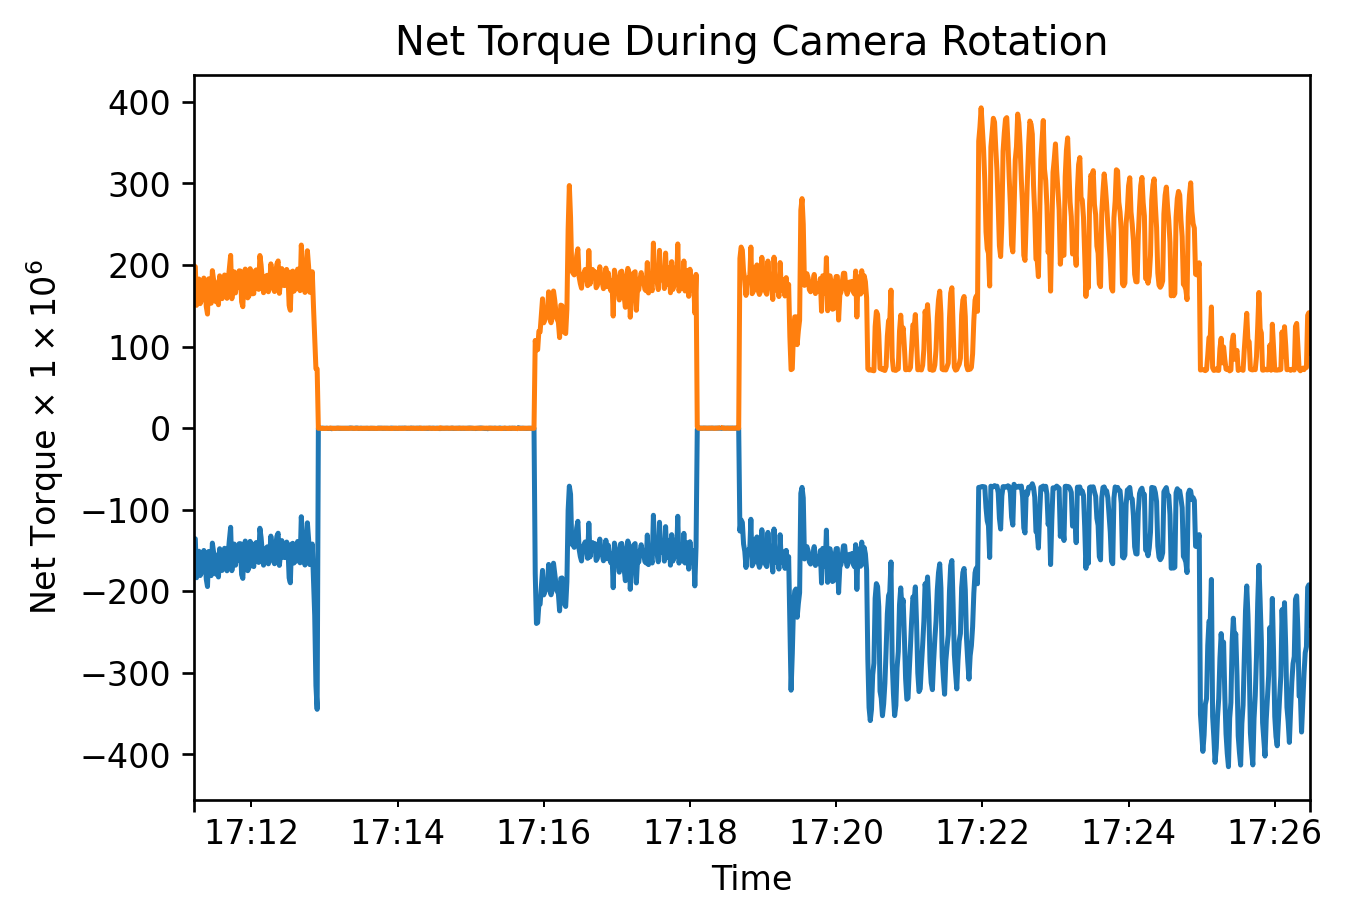

In [38]:
for i, test in enumerate(tests[:1]):
    dfs[i].current0.plot(label=f'{tests[i]}')
    dfs[i].current1.plot(label=f'{tests[i]}')
    
plt.title(r'Net Torque During Camera Rotation')
plt.xlabel(r'Time')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');
#plt.legend(ncol=2, loc='lower left', fontsize=8)


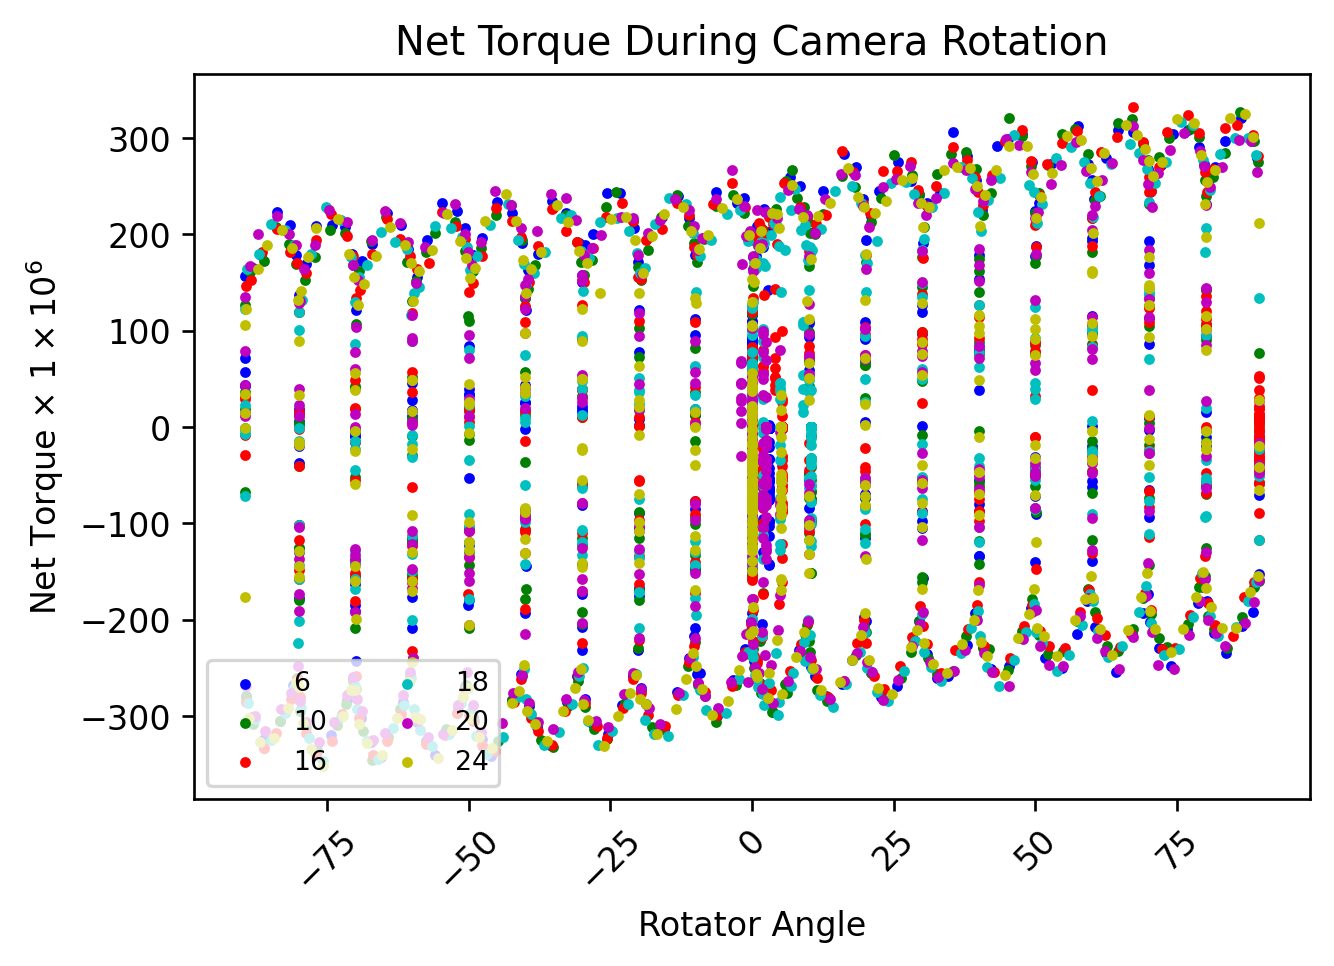

In [40]:
#dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", s=.1)

ax1 = dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", color='b', s=20.0, label=f'{tests[0]}')
ax2 = dfs[1].plot.scatter('actualPosition', 'net_torque', marker=".", color='g', s=20.0, ax=ax1, label=f'{tests[1]}')
ax3 = dfs[2].plot.scatter('actualPosition', 'net_torque', marker=".", color='r', s=20.0, ax=ax1, label=f'{tests[2]}')
ax4 = dfs[3].plot.scatter('actualPosition', 'net_torque', marker=".", color='c', s=20.0, ax=ax1, label=f'{tests[3]}')
ax5 = dfs[4].plot.scatter('actualPosition', 'net_torque', marker=".", color='m', s=20.0, ax=ax1, label=f'{tests[4]}')
ax6 = dfs[5].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{tests[5]}')


plt.title(r'Net Torque During Camera Rotation')
#plt.ylim(-.001, .001)
#plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');

plt.legend(ncol=2, loc='lower left', fontsize=8)

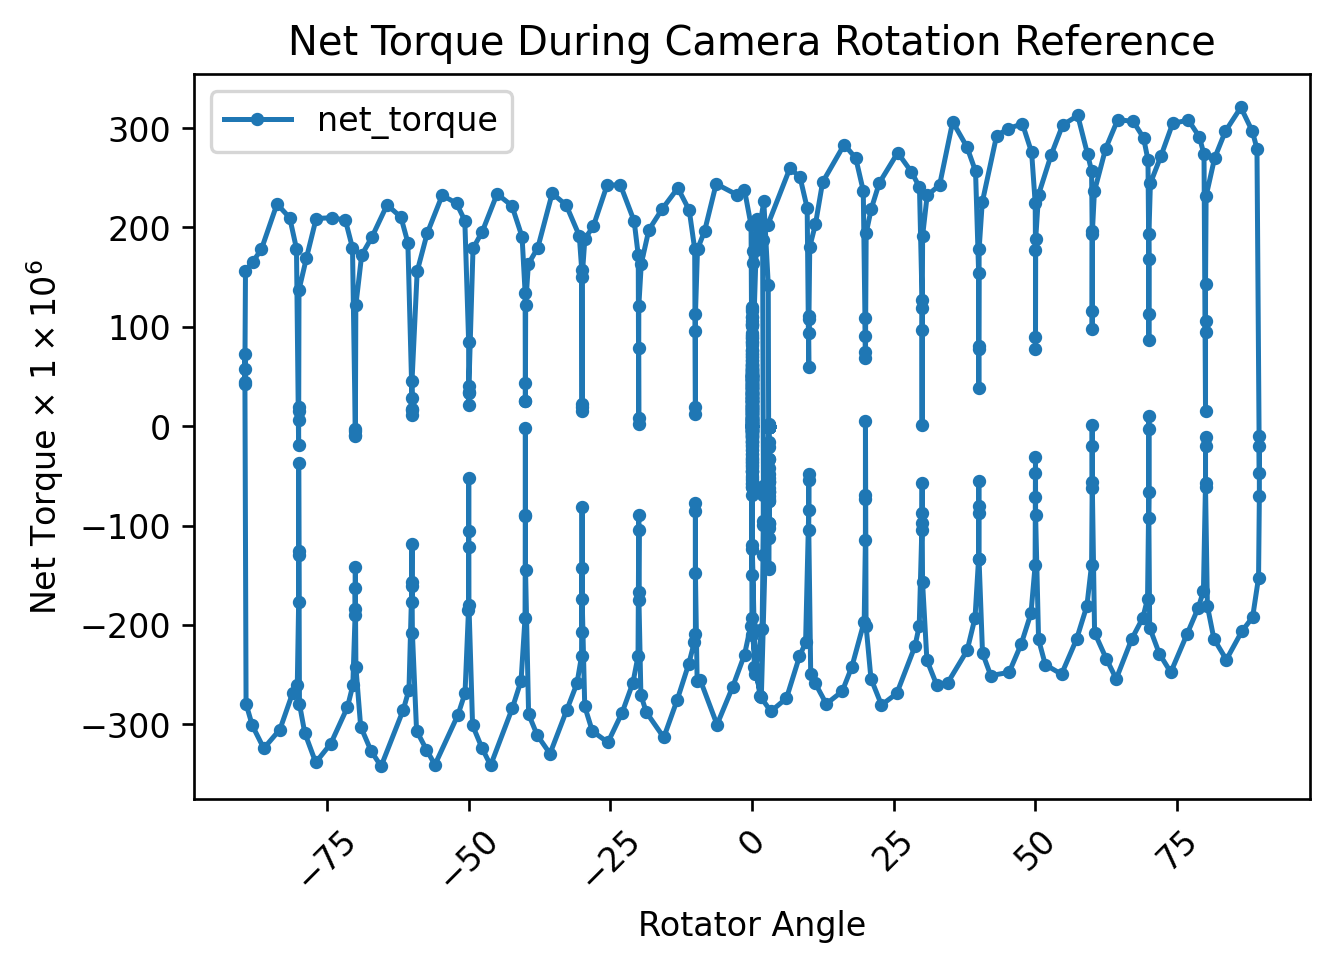

In [41]:
dfs[0].plot('actualPosition', 'net_torque', marker='.')

plt.title(r'Net Torque During Camera Rotation Reference')
#plt.xlim(-90, 0)
#plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');

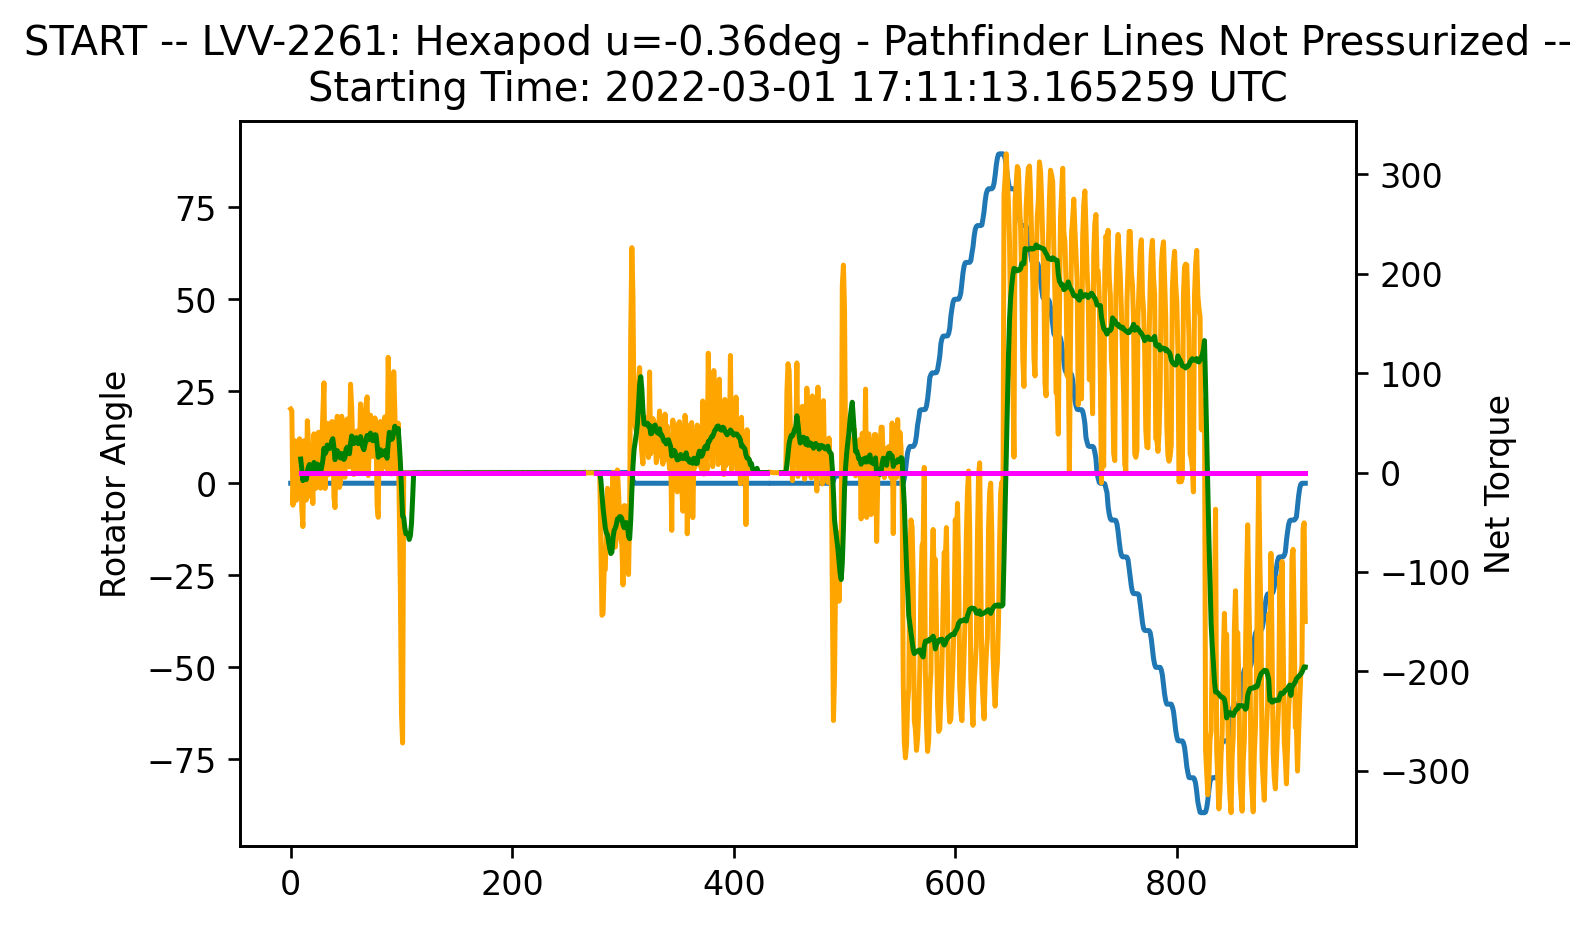

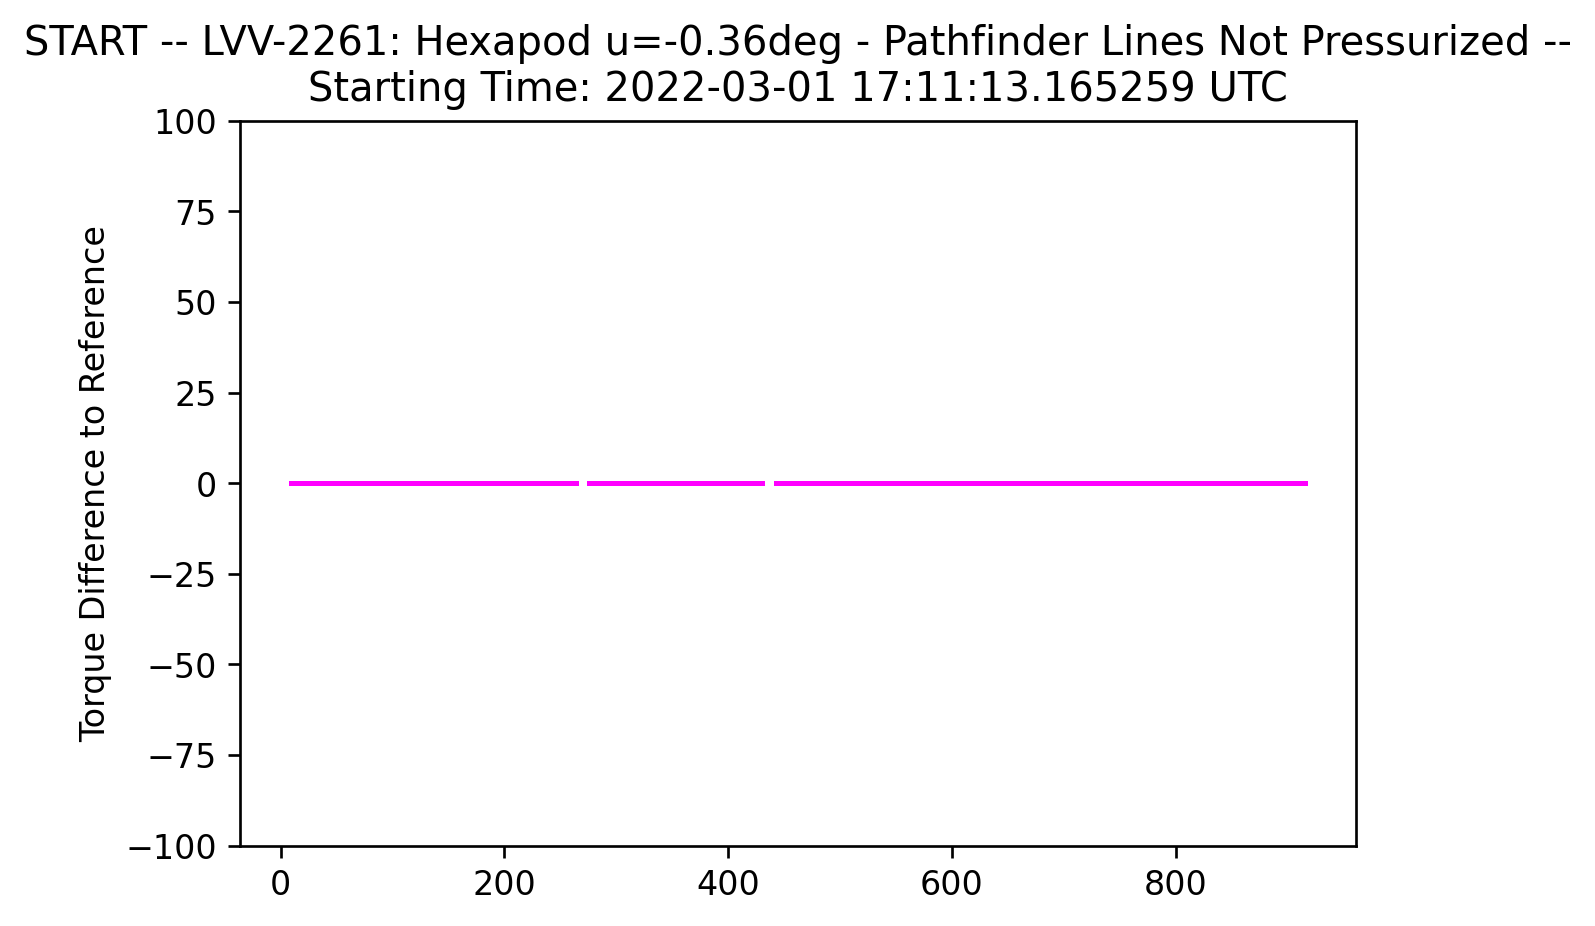

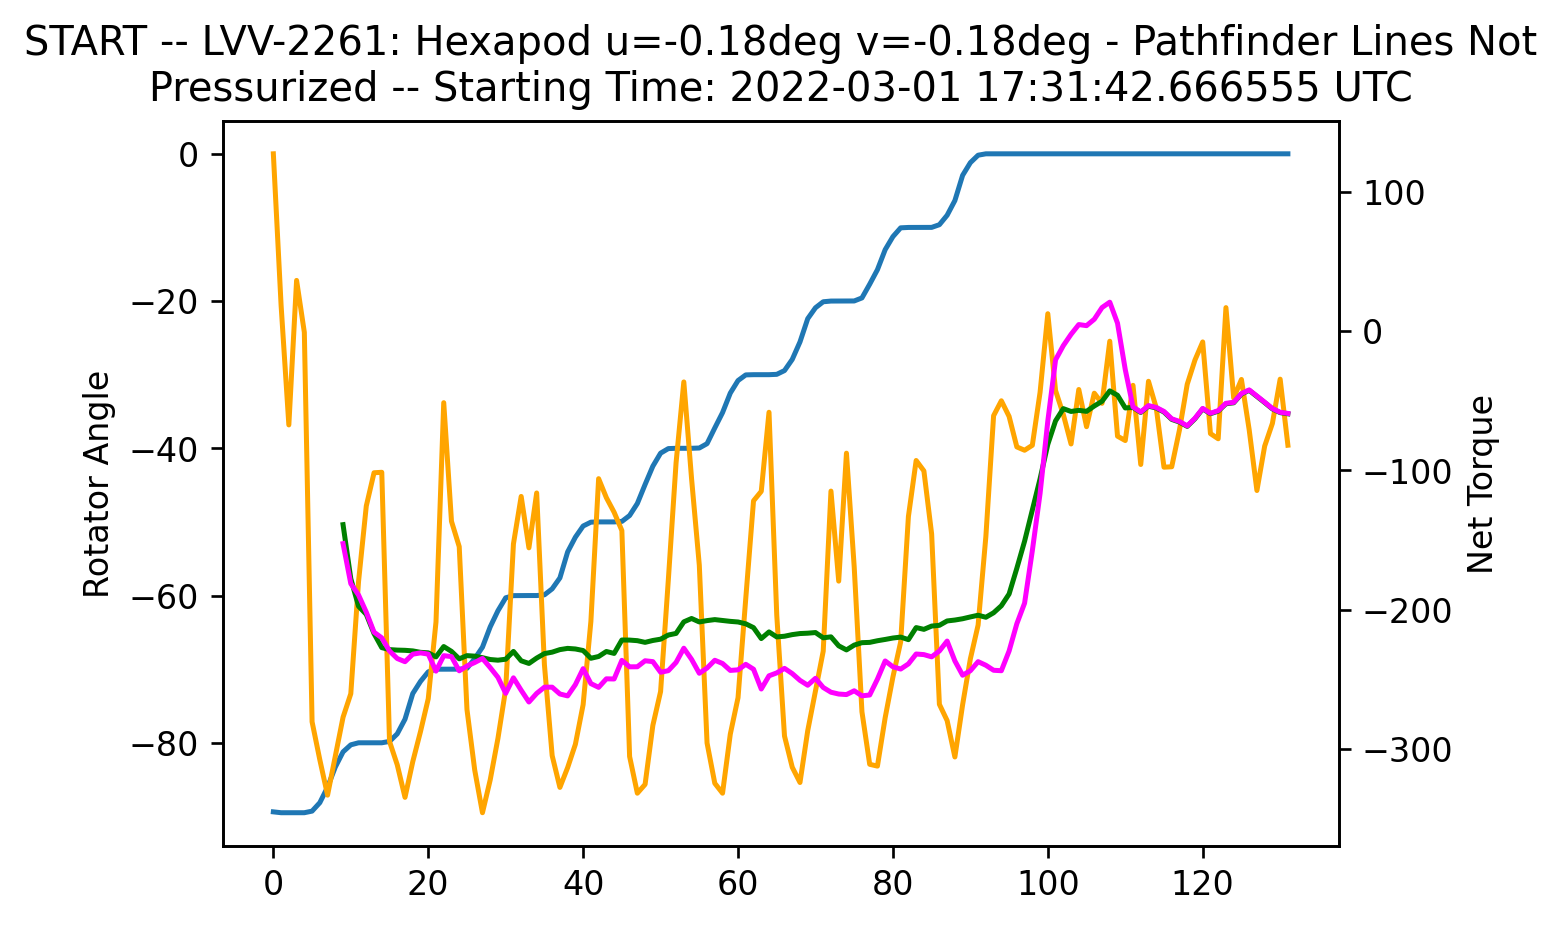

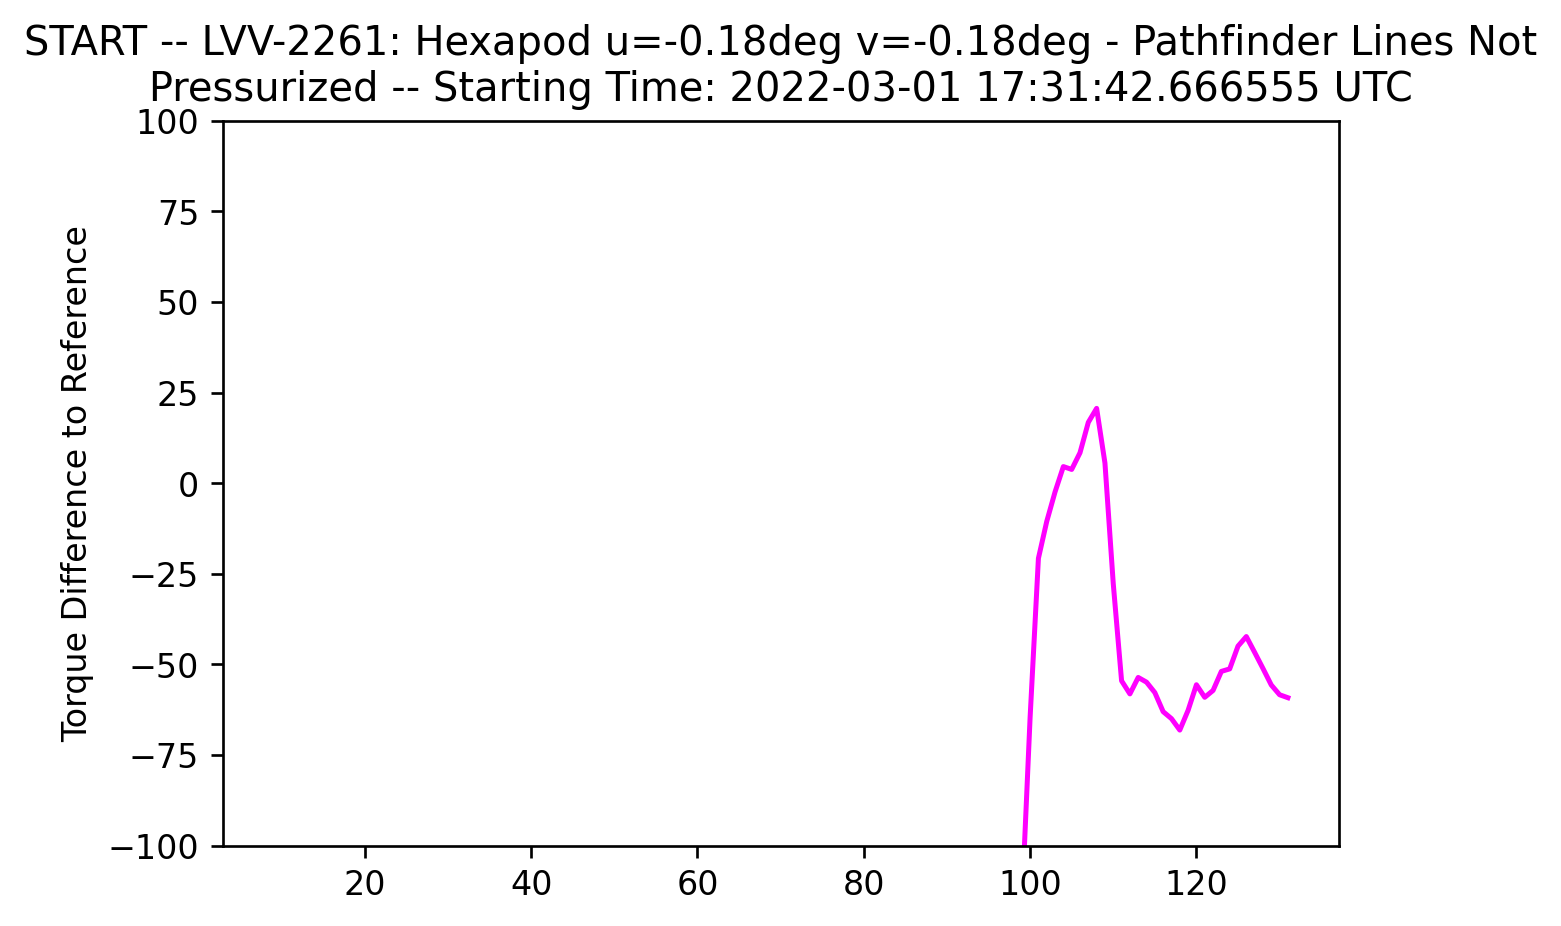

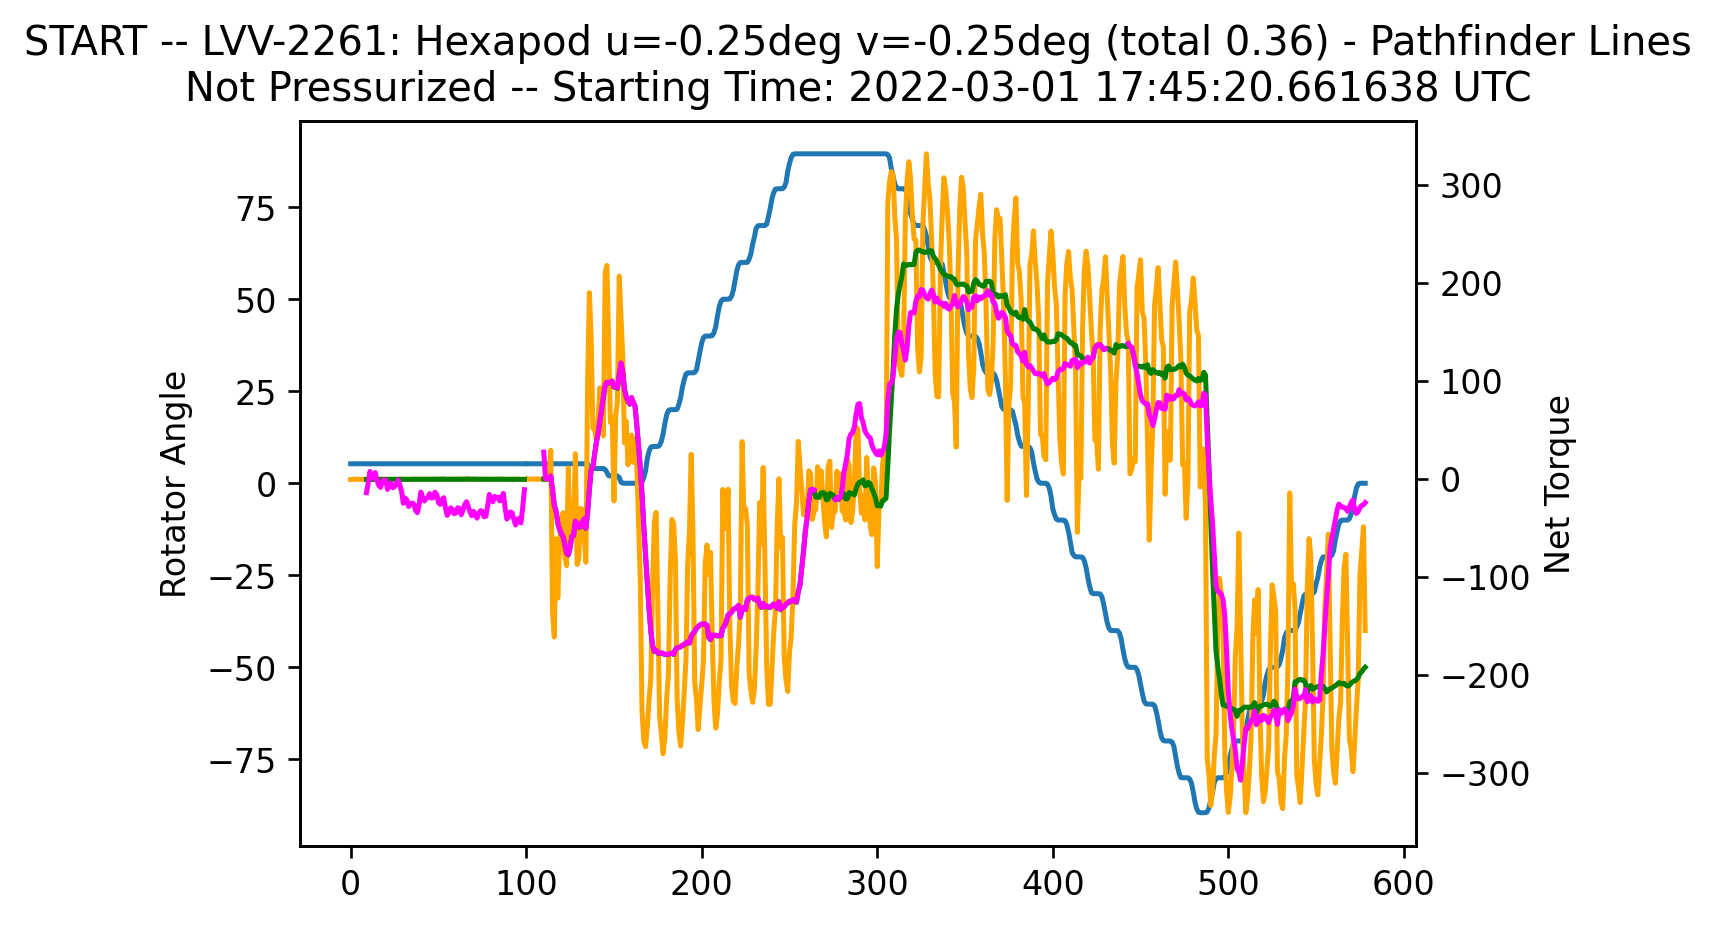

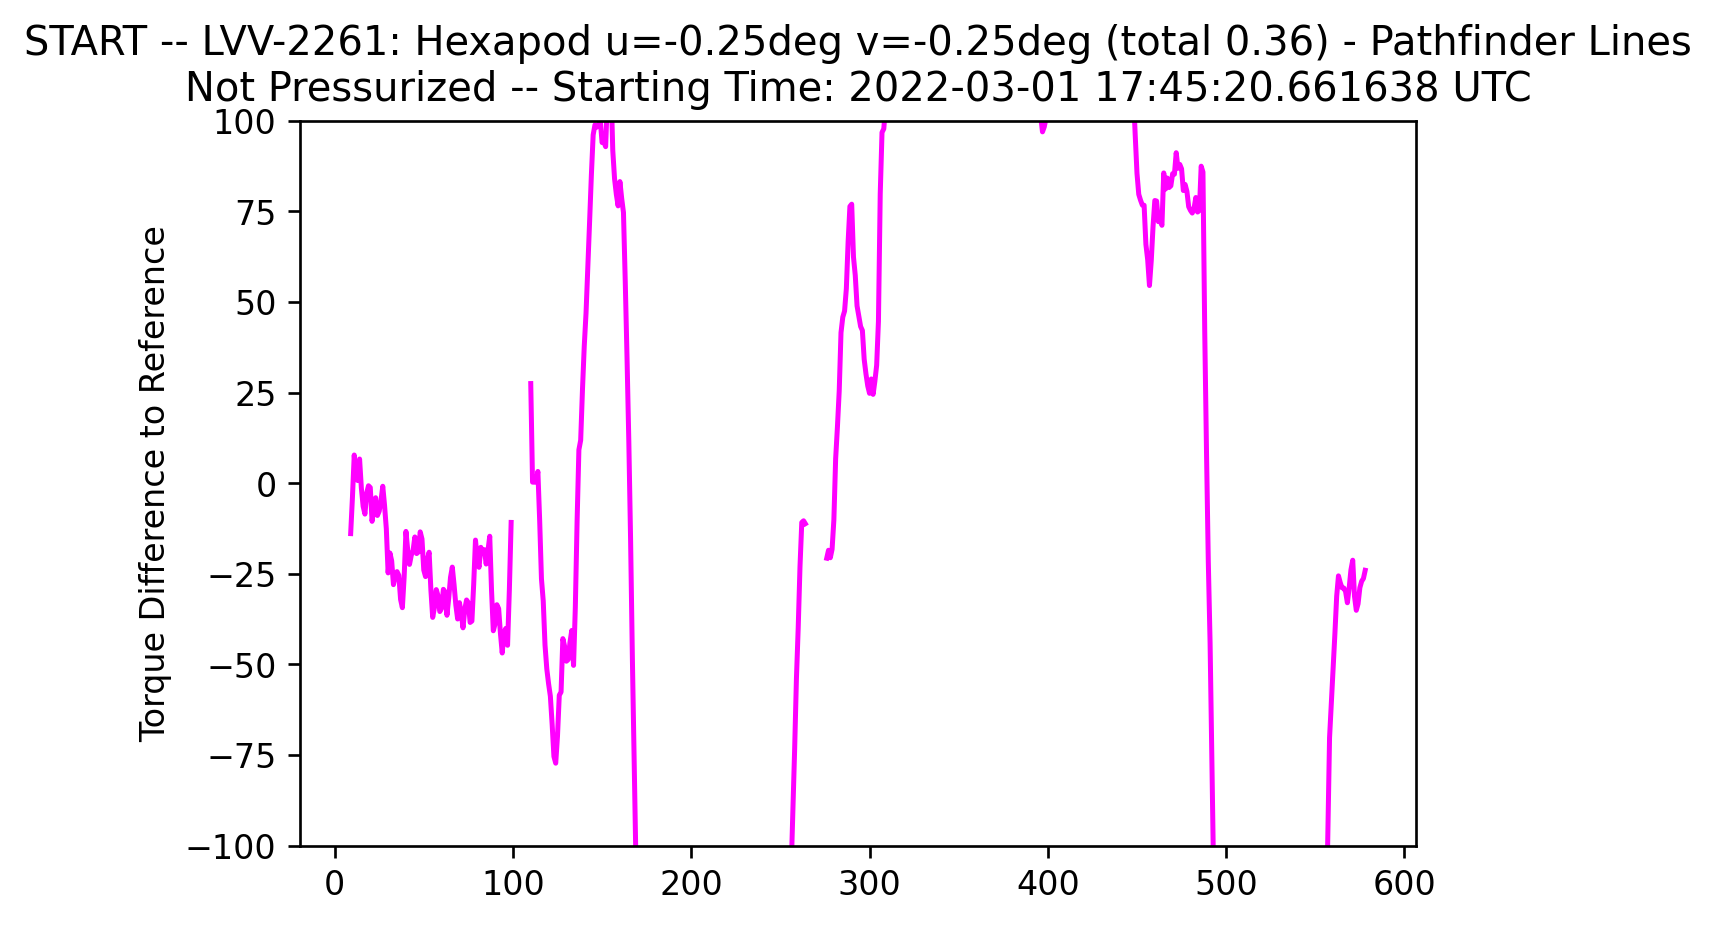

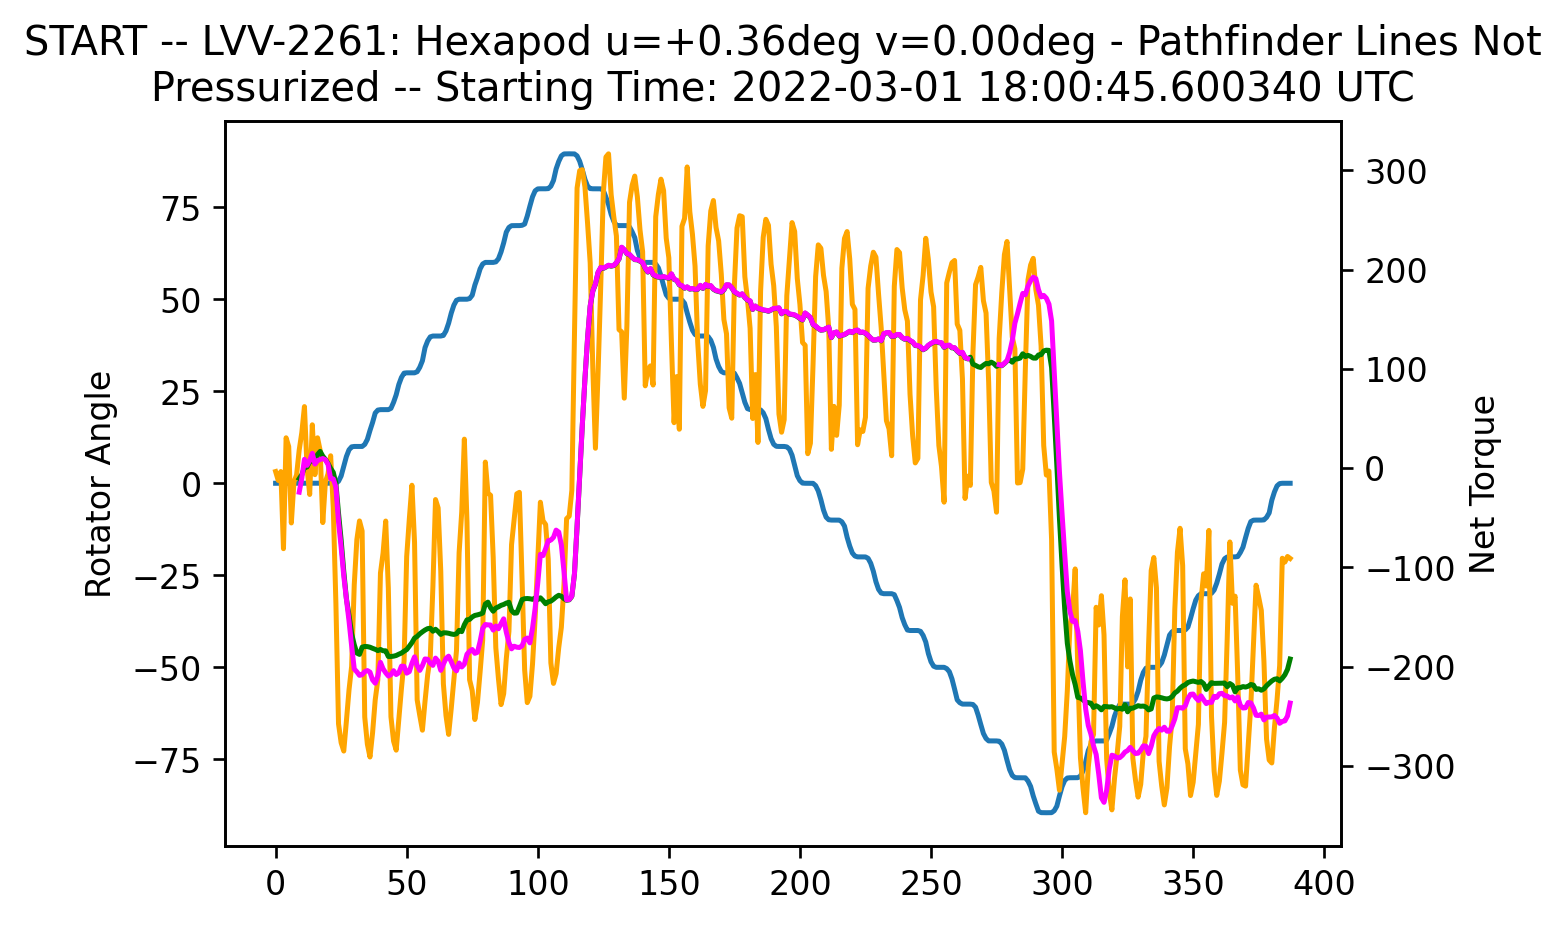

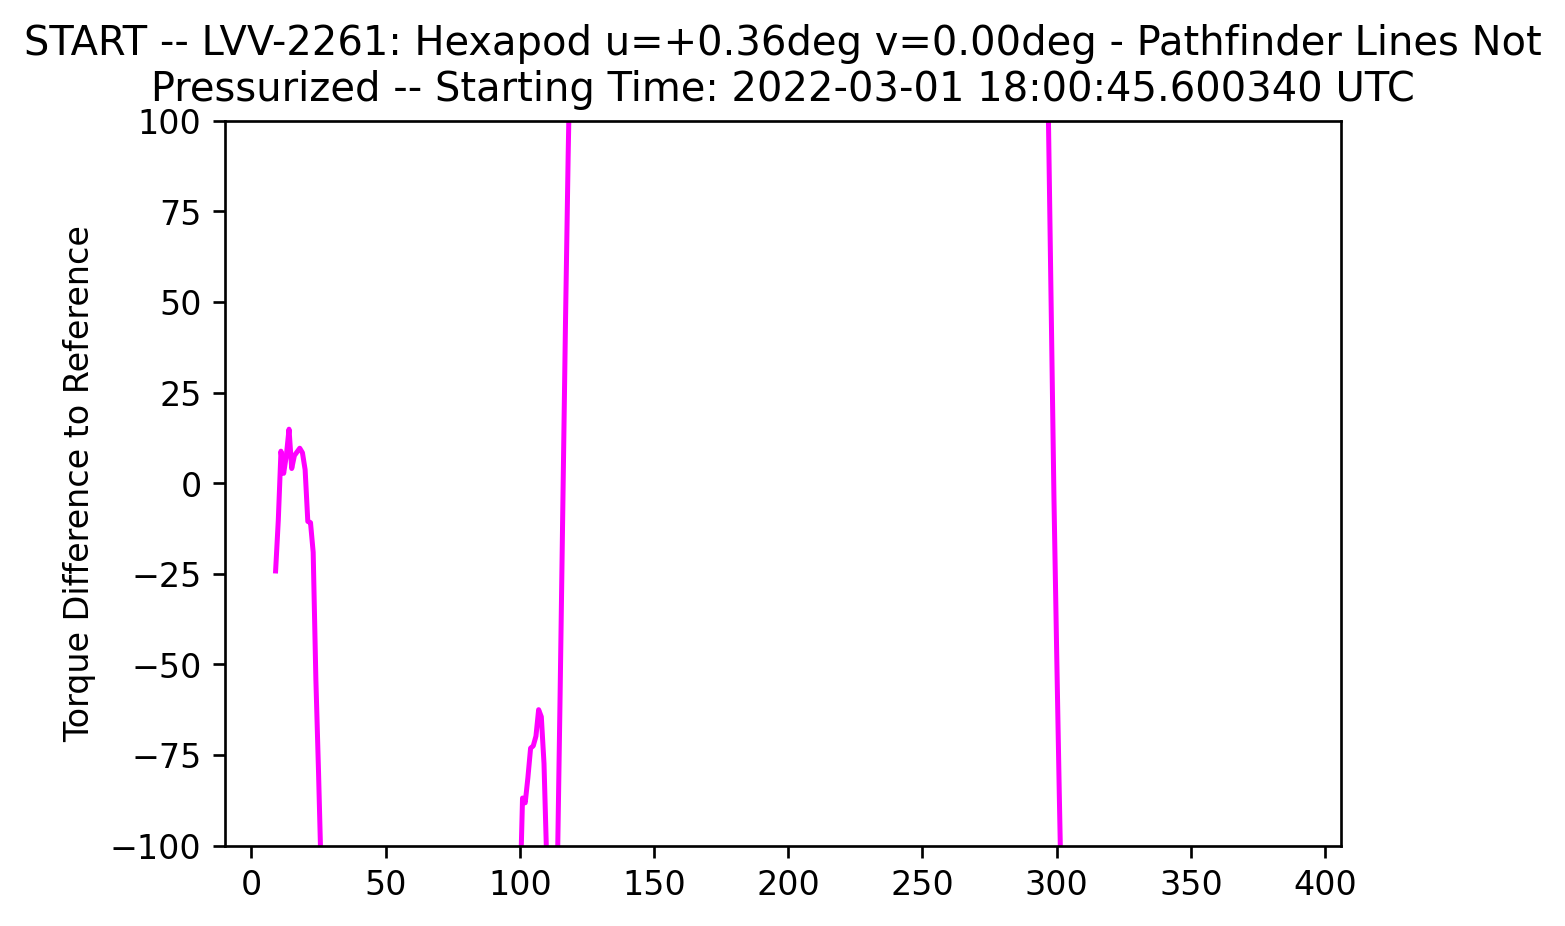

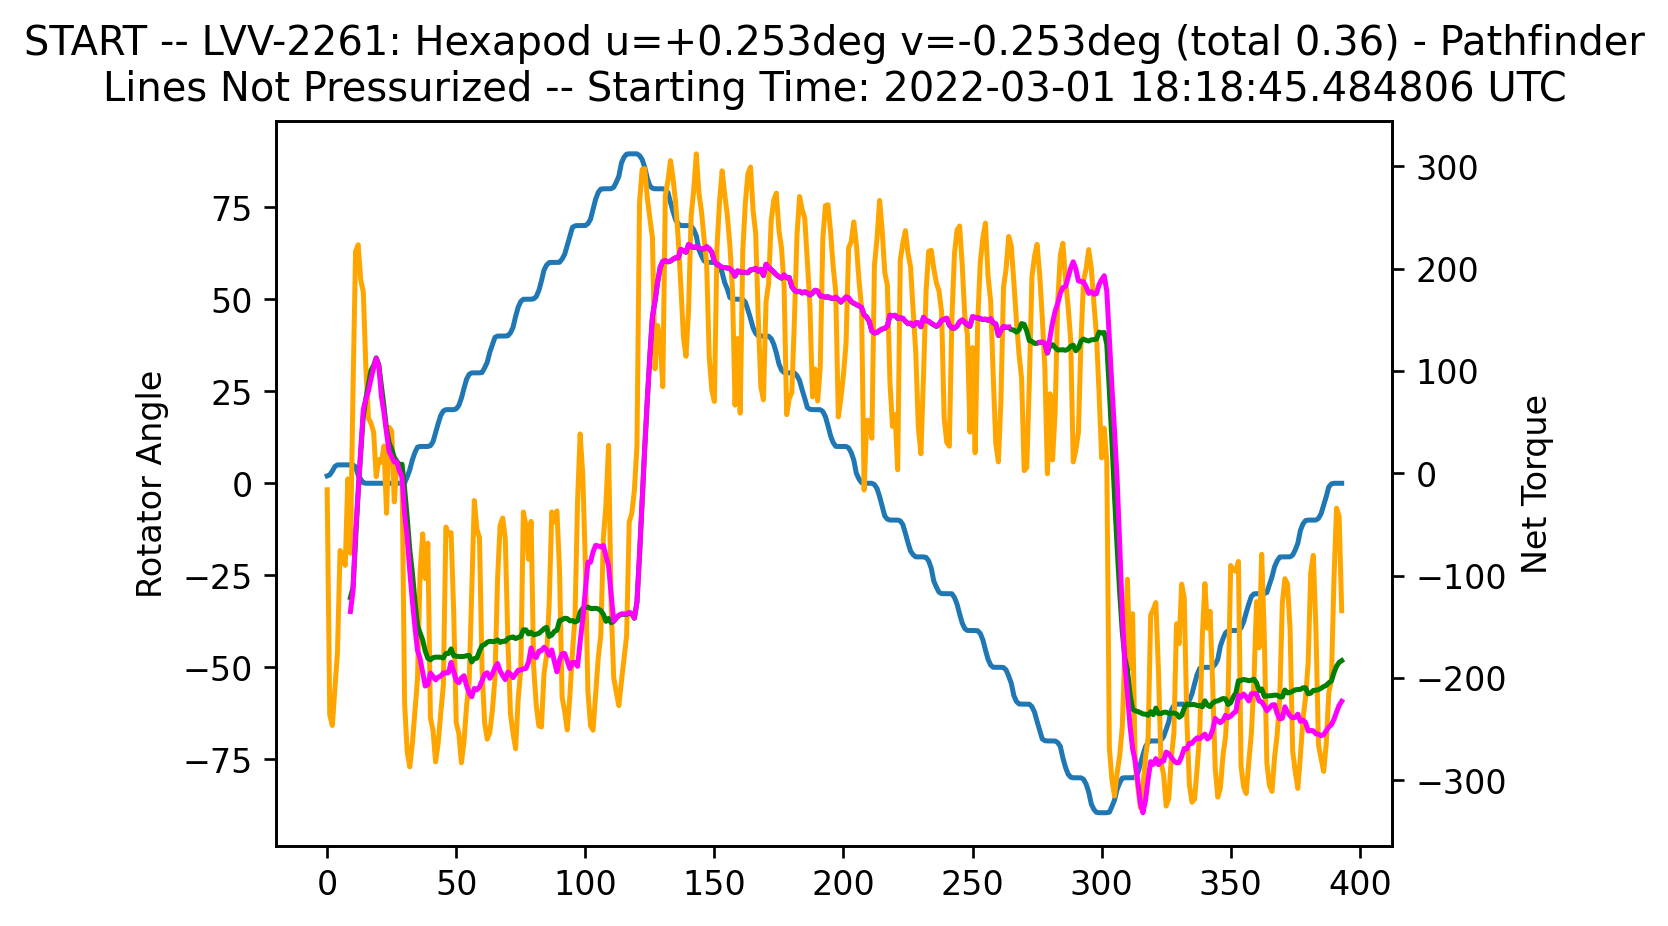

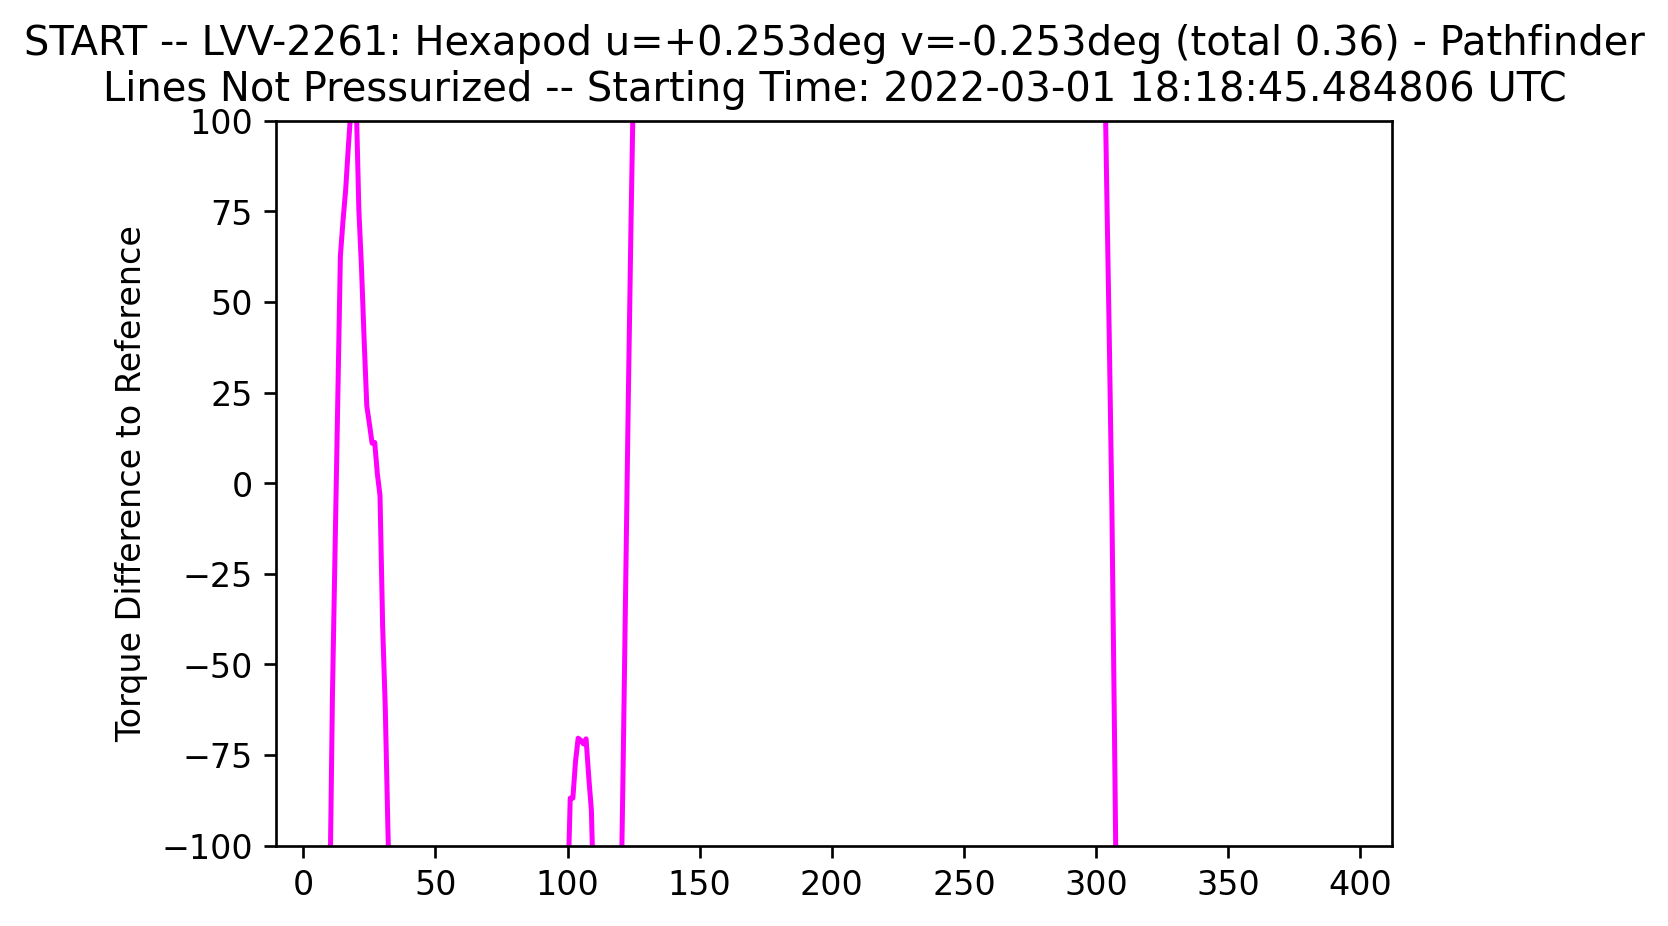

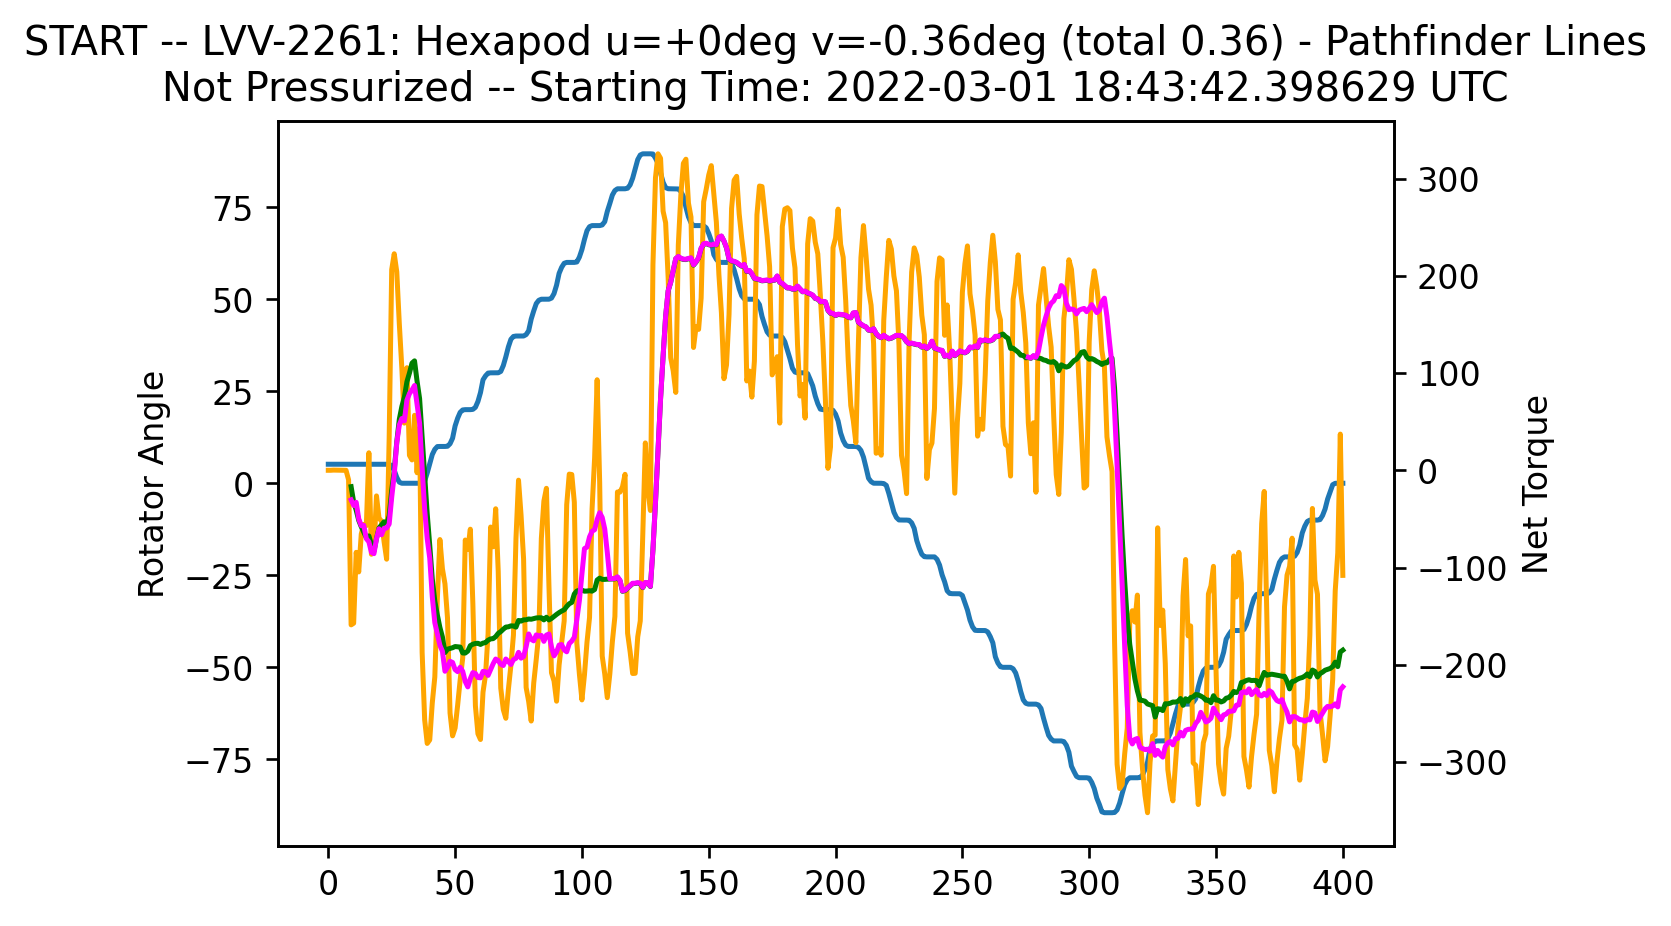

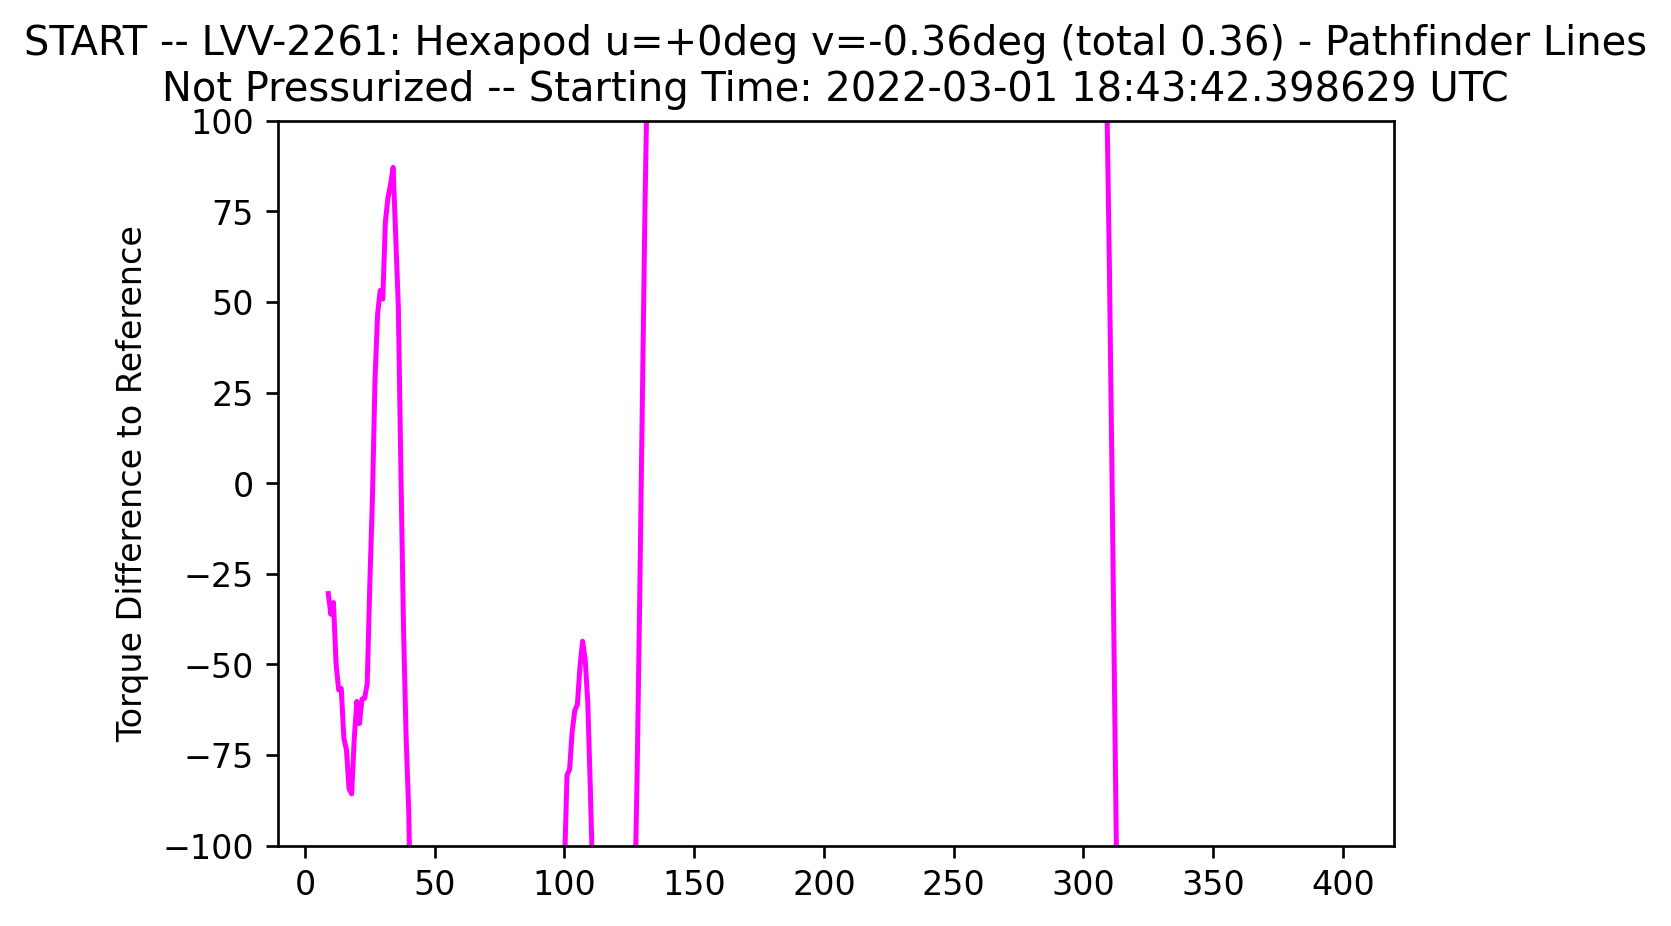

In [44]:
rotation_window = True

if rotation_window:
    starting = [0, 520, 220, 390, 400, 115]
else:
    starting = [0, 0, 0, 0, 0, 0]

reference_df = dfs[0].copy() 
reference_df.reset_index(inplace=True)    
reference_rolling = reference_df.net_torque.rolling(window=10).mean() 
    

with PdfPages('/home/cwalter/rotator.pdf') as pdf:
    for index,start in enumerate(starting):

        cut_df = dfs[index][start:].copy()
        cut_df.reset_index(inplace=True)
        cut_rolling = cut_df.net_torque.rolling(window=10).mean() 

        plt.figure()
        ax1 = cut_df.actualPosition.plot()
        ax2 = cut_df.net_torque.plot(ax=ax1.twinx(), color='orange') 

        if rotation_window:
            ax3 = cut_rolling.plot(ax=ax2, color='green') 
            ax4 = (cut_rolling-reference_rolling).plot(ax=ax2, color='magenta') 

        title_string = textwrap.fill(messages.message[tests[index]], 80)

        plt.title(title_string)
        ax1.set_ylabel('Rotator Angle')
        ax2.set_ylabel('Net Torque')
        pdf.savefig(bbox_inches='tight')

        if rotation_window:
            plt.figure()
            (cut_rolling-reference_rolling).plot(color='magenta') 

            plt.title(title_string)
            plt.ylabel('Torque Difference to Reference')
            plt.ylim(-100,100)
            pdf.savefig(bbox_inches='tight')